## Implementing RNN from Scratch
Minimal character-level language model with a Vanilla Recurrent Neural Network, in Python/numpy

원본 코드: https://gist.github.com/karpathy/d4dee566867f8291f086


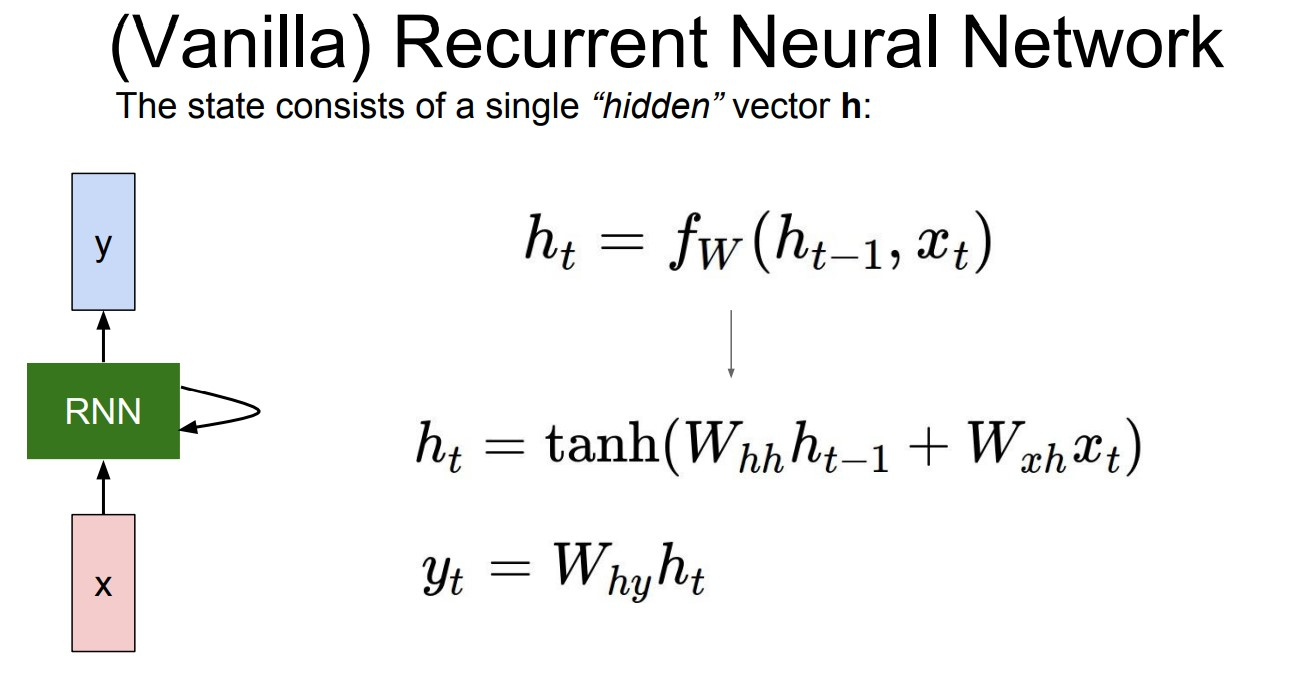

In [ ]:
import numpy as np

In [ ]:
# load text data

txt_data = "abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrstuvwxyz abcdefghijklmnopqrstuvwxyz " # input data
# txt_data = open('input.txt', 'r').read() # test external files

chars = list(set(txt_data)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(txt_data)

print("unique characters : ", num_chars) # You can see the number of unique characters in your input data.
print("txt_data_size : ", txt_data_size)

unique characters :  27
txt_data_size :  81


In [ ]:
# 문자를 숫자로

char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")

integer_encoded = [char_to_int[i] for i in txt_data] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'c': 0, 'q': 1, 'p': 2, 'v': 3, 'a': 4, 'm': 5, 'n': 6, 'd': 7, 'h': 8, 'i': 9, 'y': 10, 's': 11, 'x': 12, 'z': 13, 'o': 14, 'j': 15, 'k': 16, 'g': 17, 'w': 18, 'b': 19, 'e': 20, 'r': 21, 'l': 22, 't': 23, 'f': 24, ' ': 25, 'u': 26}
----------------------------------------------------
{0: 'c', 1: 'q', 2: 'p', 3: 'v', 4: 'a', 5: 'm', 6: 'n', 7: 'd', 8: 'h', 9: 'i', 10: 'y', 11: 's', 12: 'x', 13: 'z', 14: 'o', 15: 'j', 16: 'k', 17: 'g', 18: 'w', 19: 'b', 20: 'e', 21: 'r', 22: 'l', 23: 't', 24: 'f', 25: ' ', 26: 'u'}
----------------------------------------------------
[4, 19, 0, 7, 20, 24, 17, 8, 9, 15, 16, 22, 5, 6, 14, 2, 1, 21, 11, 23, 26, 3, 18, 12, 10, 13, 25, 4, 19, 0, 7, 20, 24, 17, 8, 9, 15, 16, 22, 5, 6, 14, 2, 1, 21, 11, 23, 26, 3, 18, 12, 10, 13, 25, 4, 19, 0, 7, 20, 24, 17, 8, 9, 15, 16, 22, 5, 6, 14, 2, 1, 21, 11, 23, 26, 3, 18, 12, 10, 13, 25]
----------------------------------------------------
data length :  81


In [ ]:
# initializate hyperparameters

iteration = 500
sequence_length = 10
batch_size = round((txt_data_size /sequence_length)+0.5) # 올림 math.ceil
hidden_size = 100  # size of hidden layer of neurons.  
learning_rate = 1e-1


# initializate model parameters(weights, biases)

# W_xh, W_hh, W_hy, b_h, b_y 행렬 크기 생각하여 작성해보기기
# weight: np.random.randn(_,_)*0.01
# bias: np.zeros

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. ex. W_xh dot 27x1 = 100x1 => 00x27
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

In [ ]:
# Forward propagation

def forward(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        # xs[t], hs[t], ys[t], ps[t] 각각 식 작성해보기
        # xs[t]: one-hot encoding
        # hs[t]: tanh
        # ps[t]: softmax function 사용

        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1

        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
        ys[t] = np.dot(W_hy, hs[t]) + b_y 
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # softmax
 
        loss += -np.log(ps[t][targets[t],0]) # cross-entropy loss  *nn.CrossEntropyLoss()

    return loss, ps, hs, xs 

In [ ]:
# Backward propagation

def backward(ps, inputs, hs, xs):

    # 변수 생성 zeros_like(변수)
    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        
        # dy: sortmax gradient
        dy = np.copy(ps[t]) 
        dy[targets[t]] -= 1

        dby += dy
        dWhy += np.dot(dy, hs[t].T)

        dh = np.dot(W_hy.T, dy) + dhnext # gradient from output and next cell 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh 
        dbh += dhraw
      
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)

    # gradient clipping to prevent exploding gradients
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # torch.nn.utils.clip_grad_norm_  
    
    return dWxh, dWhh, dWhy, dbh, dby

In [ ]:
# Training

# Adagrad를 위한 변수 생성
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 


for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # first batch에서 시작

    # batch
    for b in range(batch_size):
        
        inputs = [char_to_int[ch] for ch in txt_data[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch] for ch in txt_data[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(txt_data) and b == batch_size-1): # last batch
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forward(inputs, targets, h_prev)
#       print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backward(ps, inputs, hs, xs) 
        
        
        # parameter update with Adagrad *torch.optim.Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer, next batch
        
    if i % 50 == 0: # epoch 100 마다 print
        print ('iter %d, loss: %f' % (i, loss)) # print progress

iter 0, loss: 3.668015
iter 50, loss: 0.045266
iter 100, loss: 0.016209
iter 150, loss: 0.009519
iter 200, loss: 0.006647
iter 250, loss: 0.005067
iter 300, loss: 0.004072
iter 350, loss: 0.003388
iter 400, loss: 0.002891
iter 450, loss: 0.002513


In [ ]:
# Prediction

def predict(test_char, length):
    x = np.zeros((num_chars, 1)) 
    x[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, x) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = ''.join(int_to_char[i] for i in ixes)
    print (txt)

In [ ]:
predict('a', 10)

bcdefghijk


실전: torch.nn.RNN

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

In [ ]:
class TextRNN(nn.Module):
  def __init__(self):
    super(TextRNN, self).__init__()

    self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
    self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
    self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
    self.Softmax = nn.Softmax(dim=1)

  def forward(self, hidden, X):
    X = X.transpose(0, 1)
    outputs, hidden = self.rnn(X, hidden)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
    return model
	

model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)